1. Importar módulos

In [60]:
# Cálculos numéricos
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import cm

2. Definir datos del problema

In [61]:
#Parámetros problema
h1 = 8 #W/(m^2*K)
h2 = 20 #W/(m^2*K)
cp = 704 #J/(kg*K)
k = 2.65 #W/(m*K)
T_0 = 21.81313+273.15 #K
Tinf_interior = 21+273.15 #K
T_max = 29.59844+273.15 #K
T_min = 15.44091+273.15 #K
T_m=23.7+273.15 #K
e = 0.87
a = 0.65
p = 1875 #kg/m^3
qs_max = 1013.066 #W/m^2
espesor = 0.15 #m

#Definición cp variable
wl=6.27
ml=1.44
wr=2.91
mr=5.25
h=851
cp0=1125

Definimos la radiación solar en función del tiempo

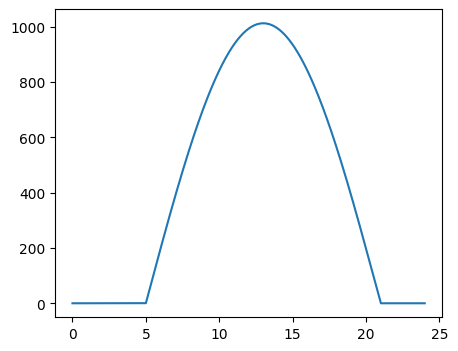

In [62]:
tiempo=np.linspace(0,24*3600,24*3600)
q_solar=qs_max*np.sin(np.pi/57600*tiempo-5*np.pi/16)
q_solar[q_solar < 0] = 0
fig, ax = plt.subplots(1, 1, figsize=[5,4])
plt.plot(tiempo/3600,q_solar)


Definición de la temperatura exterior en función del tiempo

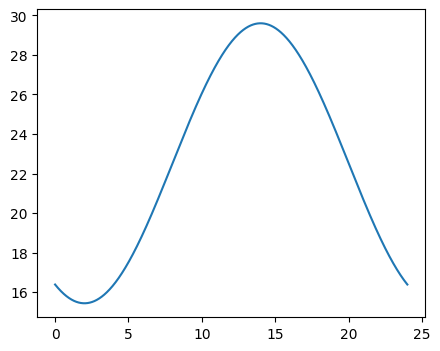

In [70]:
T_out=((T_max+T_min)/2)+((T_max-T_min)/2)*np.sin(np.pi/43200*tiempo-2*np.pi/3)
fig, ax = plt.subplots(1, 1, figsize=[5,4])
plt.plot(tiempo/3600,T_out-273.15)

3. Definición de los parámetros de grilla y computacionales. Consideraremos 100 nodos

In [64]:
# Número de nodos
n = 100
t_max=3600*16

# Crear un dominio discretizado
x = np.linspace(0,espesor,n)
t = np.linspace(0,t_max,n)

# Espaciamiento o paso radial
dx = espesor/(n-1)
print(dx)

# Paso de tiempo: Se considera Fo=0.45
dt = 0.5

# Construcción de matriz A y vector del lado derecho
A = np.zeros([n,n])
b = np.zeros(n)

0.0015151515151515152


$$
\rho c_p(T)\frac{\partial T}{\partial t}=k\frac{\partial^2T}{\partial x^2}
$$
por diferencias finitas:

$$

\rho\, c_p(T_i^n)\,\frac{T_i^{\,n+1} - T_i^{\,n}}{\Delta t}
=
k\,\frac{T_{i+1}^{\,n} - 2T_i^{\,n} + T_{i-1}^{\,n}}{\Delta x^2}

$$

$$
\frac{\rho\, c_p(T_i^n)\,T_i^{\,n+1}}{\Delta t} = k\,\frac{T_{i+1}^{\,n} - 2T_i^{\,n} + T_{i-1}^{\,n}}{\Delta x^2} + \frac{\rho\, c_p(T_i^n)\,T_i^{\,n}}{\Delta t}
$$

$$
T_i^{\,n+1} = T_i^{\,n} + \Delta t \frac{k\,}{\rho\, c_p(T_i^n)\,\Delta x^2} \{T_{i+1}^{\,n} - 2T_i^{\,n} + T_{i-1}^{\,n} \} 
$$
desde 2 a N-1:

$$
\rho c_p(T)\frac{\partial T}{\partial t}=k\frac{\partial^2T}{\partial x^2}
$$

punto fijo resuelve el parentesis:
$$
T_i^{\,n+1} = T_i^{\,n} + \Delta t \left(\frac{k\,}{\rho\, c_p(T_i^n)\,\Delta x^2} \{T_{i+1}^{\,n} - 2T_i^{\,n} + T_{i-1}^{\,n} \} \right)
$$

$$
\frac{T_i^{\,n+1} - T_i^{\,n}}{\Delta t} =  \left(\frac{k\,}{\rho\, c_p(T_i^n)\,\Delta x^2} \{T_{i+1}^{\,n} - 2T_i^{\,n} + T_{i-1}^{\,n} \} \right)
$$

$$
T_i^{\,n+1}  =  D \Delta t + T_i^{\,n}
$$

4. Rellenar nodos interiores matriz A

A se rellena en cada iteración de punto fijo, ya que no es constante. Recién ahí se puede implementar la iteración de FTCS.

5. Definir parámetros FTCS

In [65]:
# Tiempo inicial de integración
t = 0

# Tiempo final de integración
t_final = 3600*24

# Grabar resultados
write_interval = 1

6. Implementar algoritmo FTCS acoplado a método de punto fijo. Se usa método de punto fijo para construir la matriz A considerando cp variable, y una vez que se define A, se puede implementar iteración del algoritmo FTCS.

In [66]:
# Lista en que se acumulan los tiempos donde se graban los perfiles de temperatura
t_vec = []
    
# Inicializar vector con temperatura inicial (CB1)
T=np.ones(n) * T_0
    
# Copiar la temperatura T en otra variable
T_old = np.copy(T) #Actualizar método FTCS

#Guardar cp
cp_list=[]
        
# Lista con los perfiles de temperatura para cada write_interval
T_num = []

    
# Iteración de evolución FCTS
while t < t_final:

    #Actualizar método punto fijo
    T_guess = np.copy(T_old) 

    #Parámetros método punto fijo
    tol=1e9

    ###MÉTODO DE PUNTO FIJO

    #Definir iteración: iterará hasta que la tolerancia sea aceptable
    while tol>1e-3:

        #Paso 1: actualizar cp y alpha en cada nodo en cada nodo
        cp=np.zeros(n)
        for i in range(n):
        #Caso 1: T<=Tm
            if T_guess[i] <= T_m:
                cp[i] = cp0 + h*(wl**(2*ml)) / (wl**2 + (2**(1/ml)-1)*(2*T_guess[i]-2*T_m)**2)**ml
            #Caso 2: T>Tm
            else:
                cp[i] = cp0 + h*(wr**(2*mr)) / (wr**2 + (2**(1/mr)-1)*(2*T_guess[i]-2*T_m)**2)**mr
        
        #Definción alpha dado el valor de cp
        alpha=k/(p*cp)
    
        #Paso 2: Construir matriz A
        A=np.zeros((n,n))
        #Iteración en nodos interiores
        for i in range(1,n-1):
            # Coeficiente que acompaña a T_{i-1}^j
            A[i,i-1] = alpha[i]/dx**2
            # Coeficiente que acompaña a T_{i}^j
            A[i,i] = -2*alpha[i]/dx**2
            # Coeficiente que acompaña a T_{i+1}^j
            A[i,i+1] = alpha[i]/dx**2


        ###MÉTODO FCTS

        #Paso 3: Resolver FCTS

        # Actualizar nodos interiores
        T_new = T_guess + (np.dot(A,T_guess) + b)*dt   
        
        # Actualizar condiciones de borde
        #Convección interior
        T_new[0] = k/(3*k+2*h1*dx)*(4*T_new[1]-T_new[2])+h1*Tinf_interior*2*dx/(3*k+h1*2*dx)
        #Convección exterior + radiación
        q_solar=qs_max*np.sin(np.pi/57600*t-5*np.pi/16)
        if q_solar<0:
            T_new[-1] = ( k/(2*dx)*(-4*T_new[-2]+T_new[-3])
            - h2*((T_max+T_min)/2)+((T_max-T_min)/2)*np.sin(np.pi/43200*t-2*np.pi/3)) / (-3*k/(2*dx)-h2)
        else:
            T_new[-1] = ( k/(2*dx)*(-4*T_new[-2]+T_new[-3])
            - h2*((T_max+T_min)/2)+((T_max-T_min)/2)*np.sin(np.pi/43200*t-2*np.pi/3)
            - a*q_solar ) / (-3*k/(2*dx)-h2)
        
        #Paso 4: calcular tolerancia para definir si se sale de iteración de punto fijo
        tol = np.linalg.norm(T_new - T_guess)

        #Actualizar T_guess
        T_guess = np.copy(T_new) 

    # Crear una copia de la nueva temperatura
    T_old = np.copy(T_new) 

    # Actualizar tiempo
    t += dt   

    # Definir un control de flujo para guardar el perfil de temperatura
    # cada vez que se cumpla un intervalo de tiempo previamente definido
    if (t%write_interval) < 0.9*dt:      
                    
        # Guardamos el perfil de temperatura
        T_num.append(T_new)
            
        # Guardamos el tiempo
        t_vec.append(t)

        #Guardar cp
        cp_list.append(cp)

Ver si los cp varían conforme a lo esperado

7. Graficar: análisis resultados

/var/folders/l0/trjl5vrs6qd3x2t9z0zf5f5m0000gn/T/ipykernel_17733/1061159803.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cividis = cm.get_cmap("cividis", n_perfiles_deseados)


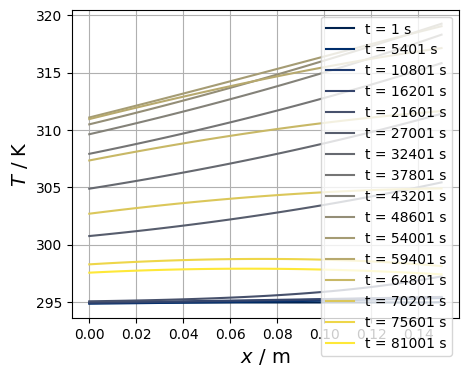

In [67]:
fig, ax = plt.subplots(1, 1, figsize=[5,4])

# Número de perfiles de temperatura totales a graficar
n_temp = len(T_num)
n_perfiles_deseados = 16
salto = max(1, n_temp // n_perfiles_deseados)

# Usar paleta de colores inclusiva
cividis = cm.get_cmap("cividis", n_perfiles_deseados)
colour = [cividis(i/n_perfiles_deseados) for i in range(n_perfiles_deseados)]

indice = 0
for k in range(0, n_temp, salto):
    plt.plot(x, T_num[k], 
             color=colour[indice % n_perfiles_deseados], 
             label="t = %.0f s" % t_vec[k])
    indice += 1

ax.set_xlabel('$x$ / m', size=14)
ax.set_ylabel('$T$ / K', size=14)
ax.grid()
ax.legend()

plt.show()

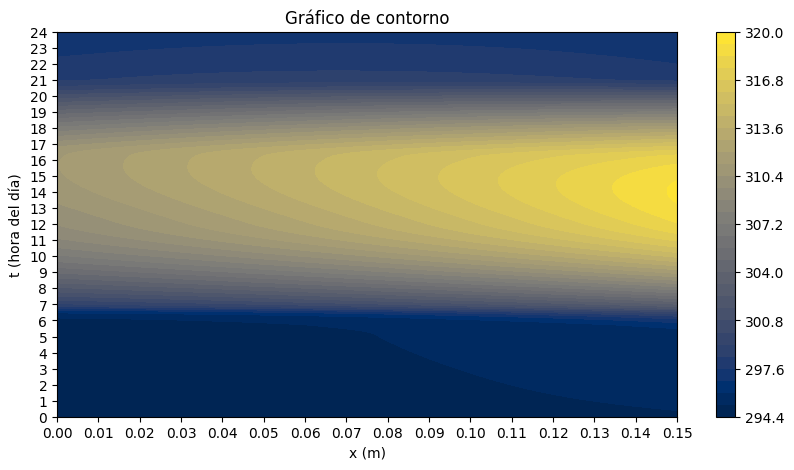

In [68]:
cm = 'cividis'
X, T = np.meshgrid(x, t_vec)
T_array = np.array(T_num)
fig, ax = plt.subplots(1,1,figsize=[10, 5])

cpf = ax.contourf(X, T/3600, T_array, cmap=cm, levels=30)
fig.colorbar(cpf, ax=ax)
ax.set_title('Gráfico de contorno')
ax.set_xlabel("x (m)")
ax.set_ylabel("t (hora del día)")
ax.set_xticks(np.arange(0, 0.16, 0.01))
ax.set_yticks(np.arange(0, 25, 1))
plt.show()



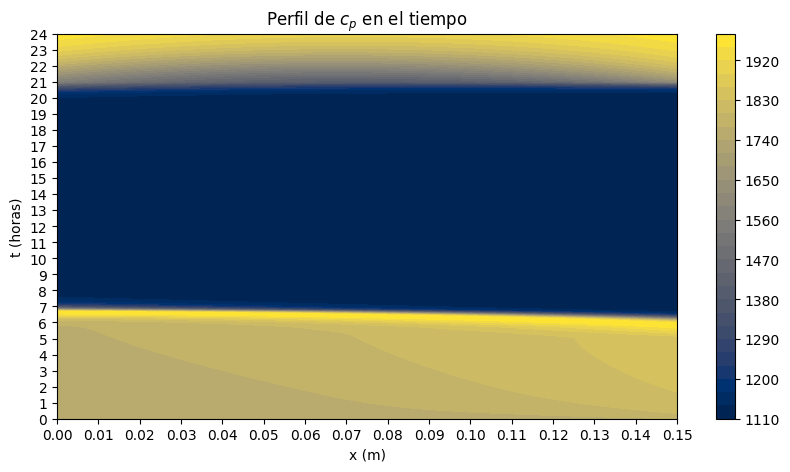

In [ ]:
X, T = np.meshgrid(x, t_vec)
cp_array = np.array(cp_list)
fig, ax = plt.subplots(1,1,figsize=[10, 5])

cpf = ax.contourf(X, T/3600, cp_array, cmap=cm, levels=30)
fig.colorbar(cpf, ax=ax)

ax.set_title("Perfil de $c_p$ en el tiempo")
ax.set_xlabel("x (m)")
ax.set_ylabel("t (horas)")
ax.set_xticks(np.arange(0, 0.16, 0.01))
ax.set_yticks(np.arange(0, 25, 1))

plt.show()